# Setup

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import normaltest, f_oneway, ttest_ind, chi2_contingency

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns

In [2]:
def corr_hmap(df, figsize= (20, 12), cbar_shrink= 0.5):
    # Plots a correlation heat map of df
    # Precondition: cbar_shrink (int) between 0 and 1
    # Precondition: df has no Nan value
    
    corr= df.corr()

    sns.set(style= 'white', rc= {'figure.figsize': figsize})
    mask= np.triu(corr)
    ax_corr= sns.heatmap(corr, annot= True, fmt= '.3f', mask= mask, vmin= -1, vmax= 1, center= 0, 
                         cmap= 'RdBu_r', linewidths= .5, cbar_kws= {"shrink": cbar_shrink})
    ax_corr.tick_params(axis ='y', rotation = 0)
    plt.show()
    sns.reset_orig()

In [3]:
def normality_test(df, segment, variable, alpha=0.05):
    unique_segment = df[segment].unique()

    # Perform D'Agostino-Pearson test for normality for each cuisine type
    for i in unique_segment:
        values = df[df[segment] == i][variable]
        if len(values) < 20:
            continue
        p_value = normaltest(values)[1]
        print(f"D'Agostino-Pearson test for {i} {variable}:")
        print(f"  p-value: {p_value:.3e}")
        if p_value > alpha:
            print(f"  Conclusion: {variable} appear to be normally distributed.")
        else:
            print(f"  Conclusion: {variable} do NOT appear to be normally distributed.")

In [4]:
def t_test(df, segment, variable, alpha=0.05):
    cuisine_types = df[segment].unique()
    t_test_results = {}

    # Step 1: Perform t-tests, assuming normal distribution
    for i in range(len(cuisine_types)):
        for j in range(i+1, len(cuisine_types)):
            cuisine_type_1 = cuisine_types[i]
            cuisine_type_2 = cuisine_types[j]

            ratings_1 = df[df[segment] == cuisine_type_1][variable]
            ratings_2 = df[df[segment] == cuisine_type_2][variable]

            t_statistic, p_value = ttest_ind(ratings_1, ratings_2)
            t_test_results[(cuisine_type_1, cuisine_type_2)] = (t_statistic, p_value)
            
            # Calculate 95% confidence intervals, assuming normal distribution
            mean_difference = np.mean(ratings_1) - np.mean(ratings_2)

            se1 = np.std(ratings_1, ddof=1) / np.sqrt(len(ratings_1))
            se2 = np.std(ratings_2, ddof=1) / np.sqrt(len(ratings_2))

            margin_of_error = 1.96 * np.sqrt(se1**2 + se2**2)

            lower_ci = mean_difference - margin_of_error
            upper_ci = mean_difference + margin_of_error

            t_test_results[(cuisine_type_1, cuisine_type_2)] += (mean_difference, (lower_ci, upper_ci))

    # Step 2: Draw violin plots
    plt.figure(figsize=(8, 4))
    ax = sns.violinplot(x=segment, y=variable, data=df)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    plt.title(f'{variable} distribution for each {segment}')
    plt.xlabel(segment)
    plt.ylabel(variable)
    plt.show()

    # Print t-test results
    for cuisine_pair, (t_statistic, p_value, mean_difference, ci) in t_test_results.items():
        print(f"T-test between {cuisine_pair[0]} and {cuisine_pair[1]}:")
        print(f"  t-statistic: {t_statistic:.3e}")
        print(f"  p-value: {p_value:.3e}")
        print(f"  Mean Difference: {mean_difference:.3e}")
        print(f"  Confidence Interval (95%): ({ci[0]:.3e}, {ci[1]:.3e})")
        if p_value < alpha:
            print(f"  Conclusion: There is significant difference in {variable}.")
        else:
            print(f"  Conclusion: There is no significant difference in {variable}.")
        print()

In [5]:
def chi_ind_test(df, var_1, var_2, alpha=0.05):
    contingency_table = pd.crosstab(df[var_1], df[var_2])

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi-square statistic: {chi2:.3e}")
    print(f"p-value: {p:.3e}")
    print("Degrees of freedom:", dof)
    print("Contingency table:")
    print(np.array(contingency_table))
    print("Expected values:")
    print(expected)
    if p > alpha:
        print(f"Conclusion: Fail to reject the null hypothesis. No significant association between {var_1} and {var_2}.")
    else:
        print(f"Conclusion: Reject the null hypothesis. There is significant association between {var_1} and {var_2}.")
        
        residuals = contingency_table - expected
        standardized_residuals = residuals / residuals.std()
        
        print()
        print("Residuals:")
        print(residuals)
        print()
        print("Standardized residuals:")
        print(standardized_residuals)

# Load Data

In [6]:
df= pd.DataFrame()
df= pd.read_csv('food_order_cleaned.csv')
df.head()

,cuisine_type,American,Chinese,French,Indian,Italian,Japanese,Korean,Mediterranean,Mexican,...,order_id,restaurant_name,day_of_the_week,weekend,cost_of_the_order,food_preparation_time,delivery_time,rating,rating_ge_5,rating_le_3
0,American,1,0,0,0,0,0,0,0,0,...,1476982,Bareburger,Weekend,1,8.73,21,19,5,1,0
1,American,1,0,0,0,0,0,0,0,0,...,1477294,The Meatball Shop,Weekend,1,12.18,22,26,5,1,0
2,American,1,0,0,0,0,0,0,0,0,...,1476963,Blue Ribbon Fried Chicken,Weekday,0,13.00,33,29,4,0,0
3,American,1,0,0,0,0,0,0,0,0,...,1478270,Shake Shack,Weekend,1,14.02,20,21,4,0,0
4,American,1,0,0,0,0,0,0,0,0,...,1477733,Lucky Strike,Weekend,1,29.25,21,21,4,0,0


# Exploratory Data Analysis

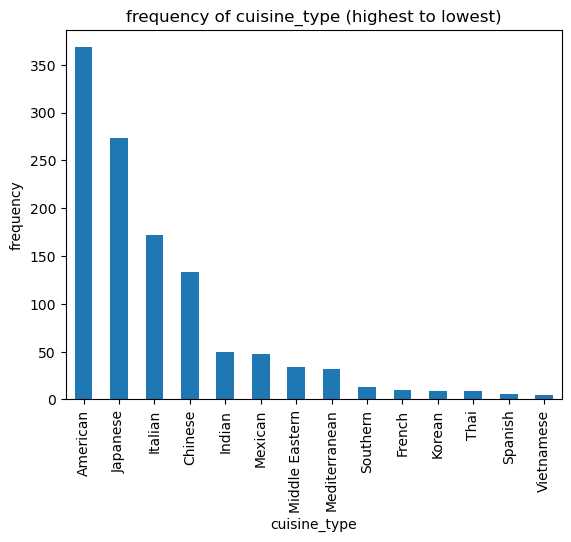

In [7]:
frequency_counts = df['cuisine_type'].value_counts()
sorted_frequency_counts = frequency_counts.sort_values(ascending=False)

sorted_frequency_counts.plot(kind='bar')
plt.xlabel('cuisine_type')
plt.ylabel('frequency')
plt.title('frequency of cuisine_type (highest to lowest)')
plt.show()

In [8]:
# cuisine_type vs. day_of_the_week
index= [df.day_of_the_week]
columns= [df.cuisine_type]

table= pd.crosstab(index, columns, margins= True, margins_name= 'total')
table

cuisine_type,American,Chinese,French,Indian,Italian,Japanese,Korean,Mediterranean,Mexican,Middle Eastern,Southern,Spanish,Thai,Vietnamese,total
day_of_the_week,,,,,,,,,,,,,,,
Weekday,111,26,2,14,62,74,2,11,16,15,4,0,1,2,340
Weekend,257,107,8,36,110,199,7,21,32,19,9,6,8,3,822
total,368,133,10,50,172,273,9,32,48,34,13,6,9,5,1162


In [9]:
# Descriptive Analysis
def quartile_25(x):
    return x.quantile(0.25)

def quartile_75(x):
    return x.quantile(0.75)

pivot_table = df.groupby('cuisine_type').agg(
    {'cost_of_the_order': ['mean', 'std', quartile_25, quartile_75],
     'rating': ['mean', 'std', quartile_25, quartile_75],
     'food_preparation_time': ['mean', 'std', quartile_25, quartile_75],
     'delivery_time': ['mean', 'std', quartile_25, quartile_75]}
)

pivot_table

cost_of_the_order                                      rating  \
                            mean       std quartile_25 quartile_75      mean   
cuisine_type                                                                   
American               16.812989  7.567816     12.1300     22.8500  4.298913   
Chinese                16.186541  7.342326     12.1300     20.8600  4.338346   
French                 20.087000  8.170813     12.1925     29.1375  4.300000   
Indian                 16.663400  7.937862      9.8550     23.8375  4.540000   
Italian                17.135930  7.348053     12.1300     22.8000  4.360465   
Japanese               16.345641  7.572002     11.8300     22.2600  4.373626   
Korean                 13.142222  6.552291     11.8400     12.6100  4.111111   
Mediterranean          15.892500  7.485357     12.1675     16.3450  4.218750   
Mexican                16.319375  8.078039     11.3475     20.5500  4.416667   
Middle Eastern         20.075882  8.139889     13.6925     28.1050  4.235294   
Southern               18.806154  7.684755     14.1200     24.2000  4.307692   
Spanish                19.718333  6.975068     13.7650     24.6275  4.833333   
Thai                   19.185556  7.756370     12.3700     24.2000  4.666667   
Vietnamese             12.806000  6.475085      7.9600     15.6700  4.000000   

                                                 food_preparation_time  \
                     std quartile_25 quartile_75                  mean   
cuisine_type                                                             
American        0.747602         4.0         5.0             27.388587   
Chinese         0.767594         4.0         5.0             27.977444   
French          0.823273         4.0         5.0             26.600000   
Indian          0.676425         4.0         5.0             26.280000   
Italian         0.747906         4.0         5.0             27.627907   
Japanese        0.727329         4.0         5.0             27.652015   
Korean          0.781736         4.0         5.0             25.333333   
Mediterranean   0.870090         3.0         5.0             27.875000   
Mexican         0.709610         4.0         5.0             25.854167   
Middle Eastern  0.698866         4.0         5.0             26.676471   
Southern        0.630425         4.0         5.0             27.153846   
Spanish         0.408248         5.0         5.0             25.333333   
Thai            0.500000         4.0         5.0             26.888889   
Vietnamese      1.000000         3.0         5.0             24.200000   

                                                 delivery_time            \
                     std quartile_25 quartile_75          mean       std   
cuisine_type                                                               
American        4.649993       23.00       31.00     24.396739  4.697404   
Chinese         4.755326       24.00       32.00     23.496241  5.061177   
French          4.526465       24.25       30.00     25.100000  3.842742   
Indian          4.426451       23.00       29.75     23.300000  4.953869   
Italian         4.693025       23.00       32.00     25.209302  4.904029   
Japanese        4.686472       24.00       32.00     23.743590  5.033729   
Korean          3.968627       23.00       26.00     21.111111  4.884784   
Mediterranean   4.844352       23.75       33.00     23.187500  5.257483   
Mexican         4.570905       22.00       28.25     24.770833  4.572069   
Middle Eastern  4.139394       23.25       29.75     24.617647  5.979838   
Southern        5.413658       24.00       33.00     22.615385  5.140338   
Spanish         3.326660       23.25       27.50     22.500000  4.549725   
Thai            5.925463       21.00       31.00     23.000000  4.213075   
Vietnamese      5.357238       20.00       25.00     27.200000  2.774887   

                                        
               quartile_25 quartile_75  
cuisine_type        

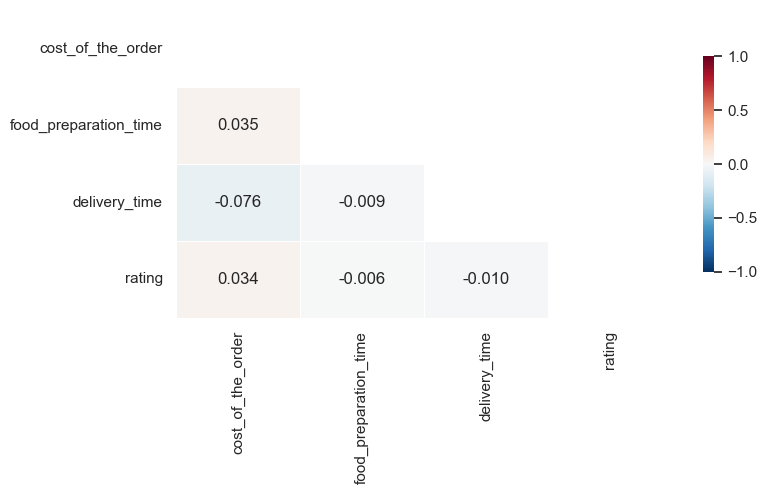

In [10]:
# Check colinearility between the continuous variables
correlation= df.iloc[:, df.columns.get_loc('cost_of_the_order'):df.columns.get_loc('rating')+1].fillna(0)
corr_hmap(correlation, figsize= (8, 4), cbar_shrink= 0.7)

# Normalilty Tests (Cuisine_Type with count >= 20)

In [11]:
# Test rating
normality_test(df, 'cuisine_type', 'rating', alpha=0.05)

D'Agostino-Pearson test for American rating:
  p-value: 4.132e-22
  Conclusion: rating do NOT appear to be normally distributed.
D'Agostino-Pearson test for Chinese rating:
  p-value: 3.434e-07
  Conclusion: rating do NOT appear to be normally distributed.
D'Agostino-Pearson test for Indian rating:
  p-value: 6.115e-03
  Conclusion: rating do NOT appear to be normally distributed.
D'Agostino-Pearson test for Italian rating:
  p-value: 2.669e-07
  Conclusion: rating do NOT appear to be normally distributed.
D'Agostino-Pearson test for Japanese rating:
  p-value: 1.630e-09
  Conclusion: rating do NOT appear to be normally distributed.
D'Agostino-Pearson test for Mediterranean rating:
  p-value: 6.353e-05
  Conclusion: rating do NOT appear to be normally distributed.
D'Agostino-Pearson test for Mexican rating:
  p-value: 4.861e-02
  Conclusion: rating do NOT appear to be normally distributed.
D'Agostino-Pearson test for Middle Eastern rating:
  p-value: 2.591e-01
  Conclusion: rating appe

In [12]:
# Test delivery_time
normality_test(df, 'cuisine_type', 'delivery_time', alpha=0.05)

D'Agostino-Pearson test for American delivery_time:
  p-value: 3.438e-08
  Conclusion: delivery_time do NOT appear to be normally distributed.
D'Agostino-Pearson test for Chinese delivery_time:
  p-value: 1.733e-08
  Conclusion: delivery_time do NOT appear to be normally distributed.
D'Agostino-Pearson test for Indian delivery_time:
  p-value: 4.327e-03
  Conclusion: delivery_time do NOT appear to be normally distributed.
D'Agostino-Pearson test for Italian delivery_time:
  p-value: 2.820e-03
  Conclusion: delivery_time do NOT appear to be normally distributed.
D'Agostino-Pearson test for Japanese delivery_time:
  p-value: 1.756e-19
  Conclusion: delivery_time do NOT appear to be normally distributed.
D'Agostino-Pearson test for Mediterranean delivery_time:
  p-value: 9.906e-02
  Conclusion: delivery_time appear to be normally distributed.
D'Agostino-Pearson test for Mexican delivery_time:
  p-value: 3.852e-04
  Conclusion: delivery_time do NOT appear to be normally distributed.
D'Agos

In [13]:
# Test cost_of_the_order
normality_test(df, 'cuisine_type', 'cost_of_the_order', alpha=0.05)

D'Agostino-Pearson test for American cost_of_the_order:
  p-value: 4.316e-09
  Conclusion: cost_of_the_order do NOT appear to be normally distributed.
D'Agostino-Pearson test for Chinese cost_of_the_order:
  p-value: 6.488e-03
  Conclusion: cost_of_the_order do NOT appear to be normally distributed.
D'Agostino-Pearson test for Indian cost_of_the_order:
  p-value: 3.229e-02
  Conclusion: cost_of_the_order do NOT appear to be normally distributed.
D'Agostino-Pearson test for Italian cost_of_the_order:
  p-value: 8.792e-05
  Conclusion: cost_of_the_order do NOT appear to be normally distributed.
D'Agostino-Pearson test for Japanese cost_of_the_order:
  p-value: 4.589e-06
  Conclusion: cost_of_the_order do NOT appear to be normally distributed.
D'Agostino-Pearson test for Mediterranean cost_of_the_order:
  p-value: 6.130e-03
  Conclusion: cost_of_the_order do NOT appear to be normally distributed.
D'Agostino-Pearson test for Mexican cost_of_the_order:
  p-value: 6.417e-02
  Conclusion: cos

In [14]:
# Test food_preparation_time
normality_test(df, 'cuisine_type', 'food_preparation_time', alpha=0.05)

D'Agostino-Pearson test for American food_preparation_time:
  p-value: 1.836e-45
  Conclusion: food_preparation_time do NOT appear to be normally distributed.
D'Agostino-Pearson test for Chinese food_preparation_time:
  p-value: 4.053e-16
  Conclusion: food_preparation_time do NOT appear to be normally distributed.
D'Agostino-Pearson test for Indian food_preparation_time:
  p-value: 2.111e-02
  Conclusion: food_preparation_time do NOT appear to be normally distributed.
D'Agostino-Pearson test for Italian food_preparation_time:
  p-value: 6.859e-27
  Conclusion: food_preparation_time do NOT appear to be normally distributed.
D'Agostino-Pearson test for Japanese food_preparation_time:
  p-value: 9.177e-44
  Conclusion: food_preparation_time do NOT appear to be normally distributed.
D'Agostino-Pearson test for Mediterranean food_preparation_time:
  p-value: 1.789e-03
  Conclusion: food_preparation_time do NOT appear to be normally distributed.
D'Agostino-Pearson test for Mexican food_prep

# ANOVA and T-Tests (Cuisine_Type with count >= 100)

In [15]:
# Select only the cuisine types with >= 100 count

cuisine_counts = df['cuisine_type'].value_counts()
cuisine_types_ge_100 = cuisine_counts[cuisine_counts >= 100].index.tolist()

df_anova = df[df['cuisine_type'].isin(cuisine_types_ge_100)]
df_anova['cuisine_type'].value_counts()

American    368
Japanese    273
Italian     172
Chinese     133
Name: cuisine_type, dtype: int64

In [16]:
# Anova test

ratings_by_cuisine = {}

for cuisine in df_anova['cuisine_type'].unique():
    ratings = df_anova[df_anova['cuisine_type'] == cuisine]['rating']
    ratings_by_cuisine[cuisine] = ratings

anova_result = f_oneway(*ratings_by_cuisine.values())

print("ANOVA Test Result:")
print(f"F-statistic: {anova_result.statistic:.3e}")
print(f"p-value: {anova_result.pvalue:.3e}")
if anova_result.pvalue > 0.05:
    print("Conclusion: Fail to reject the null hypothesis. No significant difference between the means of the groups.")
else:
    print("Conclusion: Reject the null hypothesis. There is significant difference between the means of the groups.")

ANOVA Test Result:
F-statistic: 5.980e-01
p-value: 6.164e-01
Conclusion: Fail to reject the null hypothesis. No significant difference between the means of the groups.


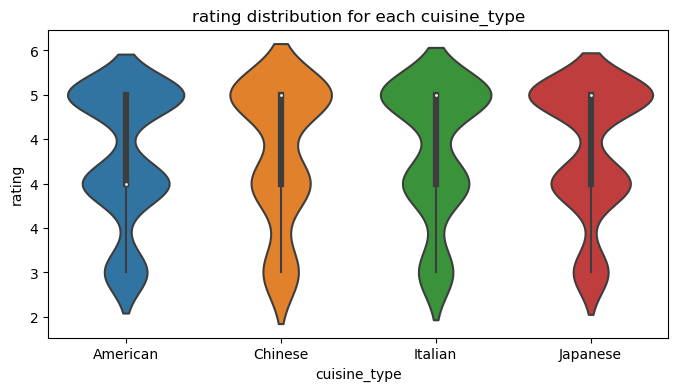

T-test between American and Chinese:
  t-statistic: -5.176e-01
  p-value: 6.049e-01
  Mean Difference: -3.943e-02
  Confidence Interval (95%): (-1.906e-01, 1.117e-01)
  Conclusion: There is no significant difference in rating.

T-test between American and Italian:
  t-statistic: -8.913e-01
  p-value: 3.732e-01
  Mean Difference: -6.155e-02
  Confidence Interval (95%): (-1.969e-01, 7.383e-02)
  Conclusion: There is no significant difference in rating.

T-test between American and Japanese:
  t-statistic: -1.266e+00
  p-value: 2.061e-01
  Mean Difference: -7.471e-02
  Confidence Interval (95%): (-1.899e-01, 4.052e-02)
  Conclusion: There is no significant difference in rating.

T-test between Chinese and Italian:
  t-statistic: -2.532e-01
  p-value: 8.003e-01
  Mean Difference: -2.212e-02
  Confidence Interval (95%): (-1.939e-01, 1.497e-01)
  Conclusion: There is no significant difference in rating.

T-test between Chinese and Japanese:
  t-statistic: -4.504e-01
  p-value: 6.526e-01
  Me

In [17]:
# T-tests

t_test(df_anova, 'cuisine_type', 'rating')

In [18]:
# Chi-square test between cuisine_type and rating 
# (In the tables, rows are cuisine types and columns are rating)
chi_ind_test(df_anova, 'cuisine_type', 'rating')

Chi-square statistic: 3.029e+00
p-value: 8.052e-01
Degrees of freedom: 6
Contingency table:
[[ 64 130 174]
 [ 24  40  69]
 [ 28  54  90]
 [ 40  91 142]]
Expected values:
[[ 60.68498943 122.53699789 184.77801268]
 [ 21.93234672  44.28646934  66.78118393]
 [ 28.36363636  57.27272727  86.36363636]
 [ 45.01902748  90.9038055  137.07716702]]
Conclusion: Fail to reject the null hypothesis. No significant association between cuisine_type and rating.


In [19]:
# Chi-square test between cuisine_type and rating_ge_5
chi_ind_test(df_anova, 'cuisine_type', 'rating_ge_5')

Chi-square statistic: 2.073e+00
p-value: 5.573e-01
Degrees of freedom: 3
Contingency table:
[[194 174]
 [ 64  69]
 [ 82  90]
 [131 142]]
Expected values:
[[183.22198732 184.77801268]
 [ 66.21881607  66.78118393]
 [ 85.63636364  86.36363636]
 [135.92283298 137.07716702]]
Conclusion: Fail to reject the null hypothesis. No significant association between cuisine_type and rating_ge_5.


In [20]:
# Chi-square test between cuisine_type and rating_le_3
chi_ind_test(df_anova, 'cuisine_type', 'rating_le_3')

Chi-square statistic: 1.126e+00
p-value: 7.708e-01
Degrees of freedom: 3
Contingency table:
[[304  64]
 [109  24]
 [144  28]
 [233  40]]
Expected values:
[[307.31501057  60.68498943]
 [111.06765328  21.93234672]
 [143.63636364  28.36363636]
 [227.98097252  45.01902748]]
Conclusion: Fail to reject the null hypothesis. No significant association between cuisine_type and rating_le_3.


In [21]:
# Chi-square test between cuisine_type and day_of_the_week 
# (In the tables, rows are cuisine types and columns are day_of_the_week)
chi_ind_test(df_anova, 'cuisine_type', 'day_of_the_week')

Chi-square statistic: 1.066e+01
p-value: 1.374e-02
Degrees of freedom: 3
Contingency table:
[[111 257]
 [ 26 107]
 [ 62 110]
 [ 74 199]]
Expected values:
[[106.1987315  261.8012685 ]
 [ 38.38160677  94.61839323]
 [ 49.63636364 122.36363636]
 [ 78.7832981  194.2167019 ]]
Conclusion: Reject the null hypothesis. There is significant association between cuisine_type and day_of_the_week.

Residuals:
day_of_the_week    Weekday    Weekend
cuisine_type                         
American          4.801268  -4.801268
Chinese         -12.381607  12.381607
Italian          12.363636 -12.363636
Japanese         -4.783298   4.783298

Standardized residuals:
day_of_the_week   Weekday   Weekend
cuisine_type                       
American         0.443186 -0.443186
Chinese         -1.142897  1.142897
Italian          1.141239 -1.141239
Japanese        -0.441527  0.441527


In [22]:
chi_ind_test(df_anova, 'American', 'weekend')

Chi-square statistic: 4.008e-01
p-value: 5.267e-01
Degrees of freedom: 1
Contingency table:
[[162 416]
 [111 257]]
Expected values:
[[166.8012685 411.1987315]
 [106.1987315 261.8012685]]
Conclusion: Fail to reject the null hypothesis. No significant association between American and weekend.


In [23]:
chi_ind_test(df_anova, 'Japanese', 'weekend')

Chi-square statistic: 4.601e-01
p-value: 4.976e-01
Degrees of freedom: 1
Contingency table:
[[199 474]
 [ 74 199]]
Expected values:
[[194.2167019 478.7832981]
 [ 78.7832981 194.2167019]]
Conclusion: Fail to reject the null hypothesis. No significant association between Japanese and weekend.


In [24]:
chi_ind_test(df_anova, 'Italian', 'weekend')

Chi-square statistic: 4.871e+00
p-value: 2.730e-02
Degrees of freedom: 1
Contingency table:
[[211 563]
 [ 62 110]]
Expected values:
[[223.36363636 550.63636364]
 [ 49.63636364 122.36363636]]
Conclusion: Reject the null hypothesis. There is significant association between Italian and weekend.

Residuals:
weekend          0          1
Italian                      
0       -12.363636  12.363636
1        12.363636 -12.363636

Standardized residuals:
weekend         0         1
Italian                    
0       -0.707107  0.707107
1        0.707107 -0.707107


In [25]:
chi_ind_test(df_anova, 'Chinese', 'weekend')

Chi-square statistic: 6.016e+00
p-value: 1.418e-02
Degrees of freedom: 1
Contingency table:
[[247 566]
 [ 26 107]]
Expected values:
[[234.61839323 578.38160677]
 [ 38.38160677  94.61839323]]
Conclusion: Reject the null hypothesis. There is significant association between Chinese and weekend.

Residuals:
weekend          0          1
Chinese                      
0        12.381607 -12.381607
1       -12.381607  12.381607

Standardized residuals:
weekend         0         1
Chinese                    
0        0.707107 -0.707107
1       -0.707107  0.707107
